In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0.5, 1.0, 'Precipitation per Day')

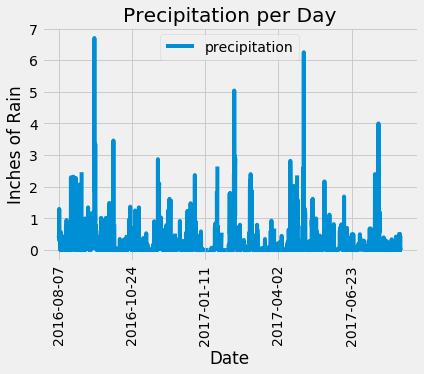

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

data_all = session.query(measurement.date).all()

# Calculate the date 1 year ago from the last data point in the database

prev_year = data_all[-365]
prev_year[0]
prev_year_date = dt.datetime.strptime(prev_year[0], '%Y-%m-%d').date()
prev_year_date

# Perform a query to retrieve the data and precipitation scores

data_12mo = session.query(measurement.date, measurement.prcp).filter(measurement.date >= prev_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(data_12mo, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values("date")
df.set_index(df['date'], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches of Rain")
plt.title("Precipitation per Day")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2116.000000
mean,0.179045
std,0.459351
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
ex = session.query(measurement.station, func.count(measurement.station))
station_list = ex.group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
act_station = station_list[0][0]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == act_station).all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, -1.340000000000014, 'Temperature')

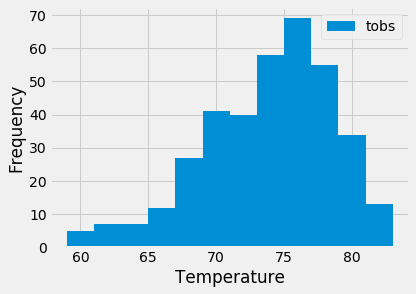

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(measurement.tobs).filter(measurement.station == act_station).filter(measurement.date >= prev_year_date).all()
df = pd.DataFrame(results)
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [69]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

prev_year_date2 = prev_year_date + dt.timedelta(days=30)

tmin, tavg, tmax = calc_temps(prev_year_date.strftime("%Y-%m-%d"), prev_year_date2.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

2016-09-06
71.0 78.26767676767676 84.0


C:\Users\Kanishka Ramanan\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


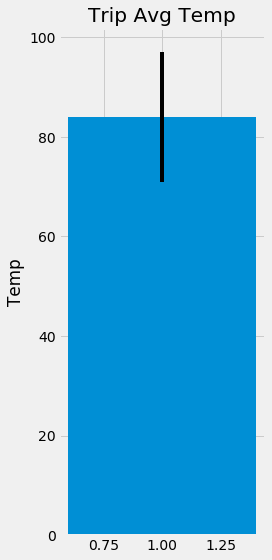

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
yerr = tmax-tmin

bar = ax.bar(1, tmax, yerr=yerr, align="center")
ax.set(title="Trip Avg Temp", ylabel="Temp")
fig.tight_layout()
fig.show()

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

selected_list = [station.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)]

rain = session.query(*selected_list).filter(measurement.station == station.station).filter(measurement.date >= prev_year_date).\
    filter(measurement.date <= prev_year_date2).group_by(station.name).order_by(func.sum(measurement.prcp).desc()).all()
print(rain)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 21.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 10.229999999999997), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.87), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 3.9399999999999995), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 3.49), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.3), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)]


In [65]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [71]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(prev_year_date, prev_year_date2, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.84, 85.0),
 (69.0, 77.0, 82.0),
 (67.0, 76.66666666666667, 83.0),
 (69.0, 76.13725490196079, 83.0),
 (68.0, 76.27083333333333, 84.0),
 (66.0, 75.91489361702128, 84.0),
 (66.0, 74.91111111111111, 81.0)]

In [72]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df1 = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df1['date'] = trip_dates
df1.set_index(['date'],inplace=True)
df1

,tmin,tavg,tmax
date,,,
2016-08-07,71.0,77.156863,83.0
2016-08-08,68.0,76.557692,83.0
2016-08-09,69.0,75.980392,81.0
2016-08-10,65.0,76.420000,83.0
2016-08-11,67.0,75.981132,82.0
2016-08-12,67.0,76.527273,83.0
2016-08-13,71.0,76.982456,84.0
2016-08-14,71.0,76.777778,82.0
2016-08-15,69.0,76.471698,83.0


Text(9.435000000000002, 0.5, 'Temperature')

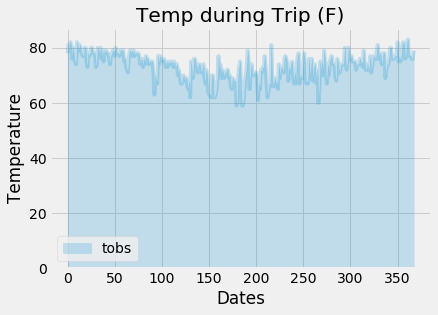

In [74]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.title("Temp during Trip (F)")
plt.xlabel("Dates")
plt.ylabel("Temperature")